## Подготовка к обучению

Необходимые импорты и установка сида

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torchvision as tv
import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Параметры обучения

In [2]:
batch_size = 600
epochs = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Импортирование датасета

In [3]:
MNIST_train = tv.datasets.MNIST('./Datasets', download=True, train=True)
MNIST_test = tv.datasets.MNIST('./Datasets', download=True, train=False)

Разбиение на обучающую и тестовую выборки

In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

Подсчет уникальных значений

In [5]:
for i in y_train.unique():
    print(f"{i}: {(y_train==i).sum()}")

0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949


Отрисовка элементов тренировочной выборки

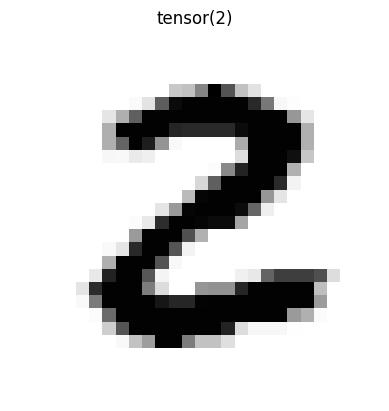

In [6]:
import matplotlib.pyplot as plt

sample_num = 25
plt.imshow(X_train[sample_num], cmap="Greys")
plt.title(y_train[sample_num])
plt.axis("off")
plt.show()

Исходная форма тензора тренировочной выборки

In [7]:
X_train.shape

torch.Size([60000, 28, 28])

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Новая форма тензора тренировочной выборки (добавили 1 канал)

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Функция для подсчета числа параметров модели

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Функция для подсчета размера паддинга

In [11]:
def padding_calc(input_matrix_shape, out_matrix_shape, kernel_size, stride):

    padding_h = (stride * (out_matrix_shape[0] - 1) - input_matrix_shape[0] +
                 kernel_size[0]) / 2
    padding_w = (stride * (out_matrix_shape[1] - 1) - input_matrix_shape[1] +
                 kernel_size[1]) / 2
    padding_size = [padding_h, padding_w]

    return padding_size


In [12]:
padding_calc([28, 28], [28, 28], [5, 5], 1)

[2.0, 2.0]

## Первый подход к созданию сети

In [13]:
class ClassicLeNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=6,
                                     kernel_size=5,
                                     padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                     out_channels=16,
                                     kernel_size=5,
                                     padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x


In [14]:
lenet = ClassicLeNet().to(device)

In [15]:
count_parameters(lenet)

61706

In [16]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3, weight_decay=0.01)

Обучение сети

In [17]:
X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet.forward(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()

        optimizer.step()

    train_preds = lenet.forward(X_train)
    accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
    
    print(accuracy)

tensor(0.9381)
tensor(0.9638)


Подсчет метрик

In [18]:
from sklearn.metrics import accuracy_score

test_preds = lenet.forward(X_test.to(device))
print(accuracy_score(y_test.numpy(), test_preds.cpu().detach().numpy().argmax(1)))

0.9641


## Другой подход

Загрузка и преобразование датасета

In [20]:
train_ds_mnist = tv.datasets.MNIST('./Datasets/', download=True, transform=trans, train=True)
test_ds_mnist = tv.datasets.MNIST('./Datasets/', download=True, transform=trans, train=False)

In [21]:
test_ds_mnist

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Создание дата-лодера

In [22]:
dataloader = torch.utils.data.DataLoader(train_ds_mnist,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=1,
                                         drop_last=False)

In [23]:
for i, j in dataloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([600, 1, 28, 28])
torch.Size([600])


In [24]:
class ClassicLeNet2(torch.nn.Module):

    def __init__(self):
        super().__init__()
        conv1 = torch.nn.Conv2d(in_channels=1,
                                out_channels=6,
                                kernel_size=5,
                                padding=2)
        act1 = torch.nn.Tanh()
        pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        conv2 = torch.nn.Conv2d(in_channels=6,
                                out_channels=16,
                                kernel_size=5,
                                padding=0)
        act2 = torch.nn.Tanh()
        pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        act3 = torch.nn.Tanh()

        fc2 = torch.nn.Linear(120, 84)
        act4 = torch.nn.Tanh()

        fc3 = torch.nn.Linear(84, 10)

        self.model_part1 = torch.nn.Sequential(conv1, act1, pool1, conv2, act2,
                                               pool2)
        self.model_part2 = torch.nn.Sequential(fc1, act3, fc2, act4, fc3)

    def forward(self, x):
        out1 = self.model_part1(x)
        out2 = out1.view(out1.size(0),
                         out1.size(1) * out1.size(2) * out1.size(3))
        out3 = self.model_part2(out2)

        return out3


In [25]:
lenet = ClassicLeNet2().to(device)

In [26]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3, weight_decay=0.01)

Обучение сети

In [27]:
def accuracy(pred, label):
  answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1)
  return answer.mean()

In [28]:
for epoch in range(epochs):
    for img, label in (pbar := tqdm(dataloader)):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.to(device)

        label = F.one_hot(label, 10).float()
        preds = lenet.forward(img)
        
        loss = loss_fn(preds, label)
        loss.backward()

        optimizer.step()

        acc_current = accuracy(preds.cpu(), label.cpu())
        pbar.set_description(f'accuracy: {acc_current:.3f}')


accuracy: 0.948: 100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Подсчет метрик

In [38]:
X_test = test_ds_mnist.data.unsqueeze(1).float()
y_test = test_ds_mnist.targets

test_preds = lenet.forward(X_test.to(device))
print(accuracy(test_preds.cpu(), F.one_hot(y_test, 10).float().cpu()))

0.8465
